# De-identify medical images with the help of Amazon Comprehend Medical and Rekognition

Medical images are a foundational tool in modern medicine that enable clinicians to visualize critical information about a patient to help diagnose and treat them. The digitization of medical images has vastly improved our ability to reliably store, share, view, search, and curate these images to assist our medical professionals. The number of modalities for medical images has also increased. From CT scans to MRIs, digital pathology to ultrasounds, there are vast amounts of medical data collected in medical image archives.

These medical images are also useful for medical research. Using machine learning, our global medical research institutions are now pressing forward into insights that can only be gained by analyzing hundreds of thousands or millions of images. Accomplishing this while complying with regulatory obligations like the Health Information Portability and Accountability Act (HIPAA) can be challenging for medical professionals. Often, these medical images contain Protected Health Information (PHI) stored as text within the image itself. This has historically presented a challenge because removing this PHI required manual review and editing of the image. This manual process can easily take many minutes per image and makes de-identifying large datasets time consuming and expensive.

Last year, Amazon announced the ability to easily detect and extract text from images using our machine learning service [Amazon Rekognition](https://aws.amazon.com/about-aws/whats-new/2017/11/amazon-rekognition-announces-real-time-face-recognition-text-in-image-recognition-and-improved-face-detection/ "Amazon Rekognition"). This year, we announced a new machine learning Natural Language Processing (NLP) service for medical text called [Amazon Comprehend Medical](https://aws.amazon.com/about-aws/whats-new/2018/11/introducing-amazon-comprehend-medical/) that can help customers to detect and identify PHI in a string of text. Combining these two services together with some Python code, as demonstrated below, can help customers inexpensively and quickly detect, identify, and redact PHI from within medical images.


## De-identification architecture

In this example, we will use the Notebooks feature of Amazon SageMaker to create an interactive notebook with Python code. These notebooks are just one part of Amazon SageMaker, a fully-managed service that covers the entire machine learning workflow to label and prepare your data, choose an algorithm, train the algorithm, tune and optimize it for deployment, make predictions, and take action. In this example though, for the actual machine learning and prediction, we will be using Amazon Rekognition to extract text from the images and Amazon Comprehend Medical to help us to identify and detect the PHI. All of our image files will be read from and written to a bucket in Amazon Simple Storage Service (Amazon S3), an object storage service that offers industry-leading scalability, data availability, security, and performance.

![alt-text](de-identify-medical-images-blog-post.jpg "diagram")

When using Amazon Comprehend Medical to detect and identify protected health information, please note that the service provides confidence scores for each identified entity that indicates the level of confidence in the accuracy of the detected entity. You should take these confidence scores into account and review identified entities to make sure they are correct and appropriate for your use case.  For more information about confidence scores, please see the [Amazon Comprehend Medical documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-medical-phi.html).


## Using the notebook

This notebook shows an example chest x-ray image from a dataset made available by the NIH Clinical Center.  The dataset can be downloaded from [this link](https://nihcc.app.box.com/v/ChestXray-NIHCC).  Please see the NIH Clinical Center’s [CVPR 2017 paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) for more information.

At the very beginning of the notebook, you will see 5 parameters you can adjust to control the de-identification process outlined in this example.
  
* **bucket** defines the S3 bucket where images will be read from and written to.
* **object** defines the identified image that you want to de-identify. These can be PNG, JPG, or DICOM images.  If the object ends with the extension ‘.dcm’, then the image is assumed to be a DICOM image and the ImageMagick utility will be used to convert it to PNG format before processing it.
* **redacted_box_color** defines the color that will be used to cover up identified PHI text within the image.
* **dpi** defines the dpi setting that will be used in the output image
* **phi_detection_threshold** is the threshold for the confidence score mentioned above (between 0.00 and 1.00). Text detected and identified by Amazon Comprehend Medical must meet the minimum confidence score you set to be redacted from the output image. The default value of 0.00 will redact all text that Amazon Comprehend Medical has detected an identified as PHI, regardless of the confidence score.




In [ ]:
#ImageMagick is used to convert DICOM images to PNG if the image extension ends with .dcm
#If ImageMagick is not installed, install it.
! sudo yum install -y ImageMagick

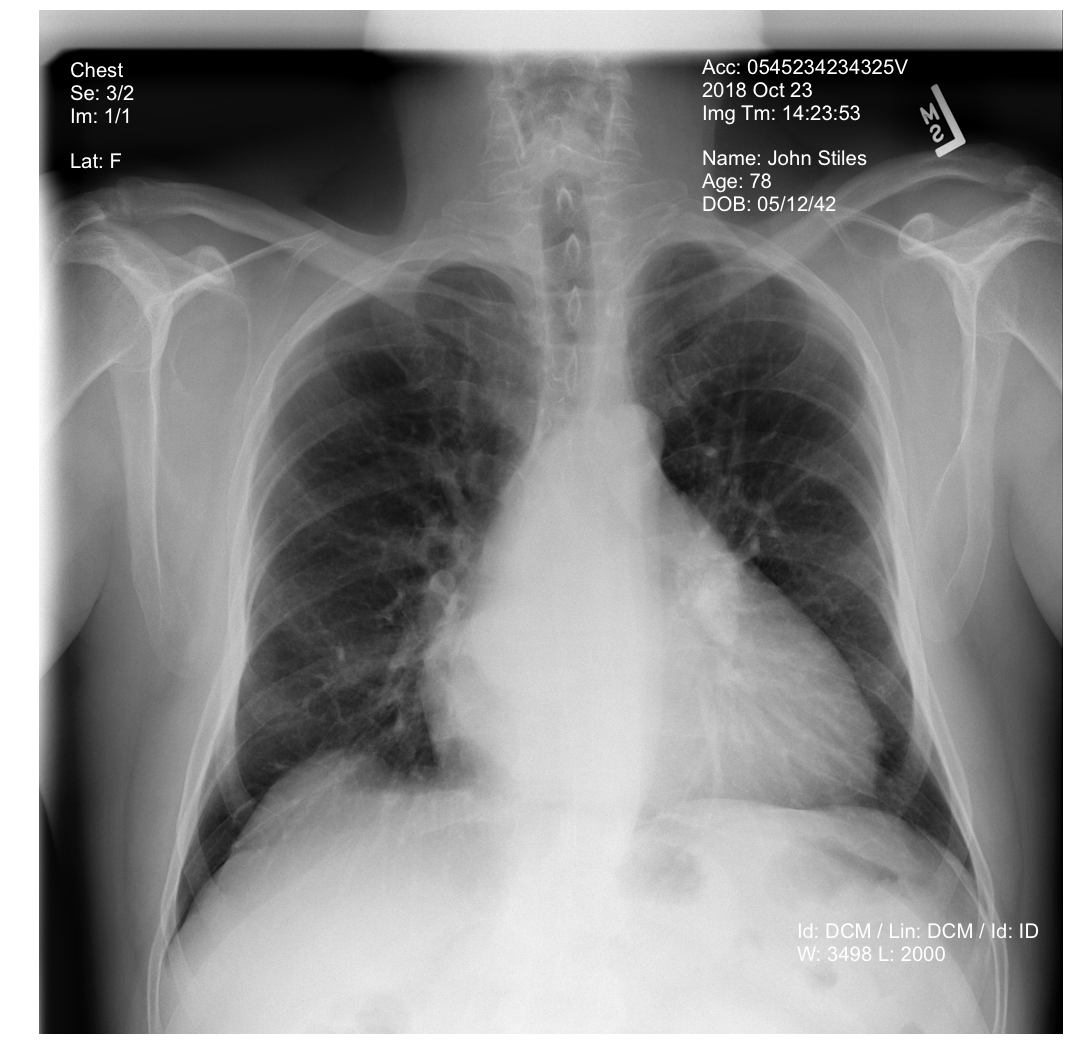

In [1]:
#Define the S3 bucket and object for the medical image we want to analyze.  Also define the color used for redaction.
bucket='aws-ml-blog'
object='artifacts/de-id-medical-images/test.png'
redacted_box_color='red'
dpi = 72
phi_detection_threshold = 0.00


#If the image is in DICOM format, convert it to PNG
if (object.split(".")[-1:][0] == "dcm"):
    ! aws s3 cp s3://{bucket}/{object} .
    ! convert -format png {object.split("/")[-1:][0]} {object.split("/")[-1:][0]}.png
    ! aws s3 cp {object.split("/")[-1:][0]}.png s3://{bucket}/{object}.png
    object=object+'.png'
    print(object)

#Import all of the required libraries
%matplotlib inline
import boto3
import json
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib as mpl
from imageio import imread

import base64
import cStringIO

#Implement AWS Services
rekognition=boto3.client('rekognition')
comprehendmedical = boto3.client(service_name='comprehendmedical')
s3=boto3.resource('s3')

#Download the image from S3 and hold it in memory
img_bucket = s3.Bucket(bucket)
img_object = img_bucket.Object(object)
xray = io.BytesIO()
img_object.download_fileobj(xray)
img = np.array(Image.open(xray), dtype=np.uint8)

#Set the image color map to grayscale, turn off axis graphing, and display the image
height, width = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
# Display the image.
ax.imshow(img, cmap='gray')
plt.show()

In [2]:
#Use Amazon Rekognition to detect all of the text in the medical image
#response=rekognition.detect_text(Image={'S3Object':{'Bucket':bucket,'Name':object}})
response=rekognition.detect_text(Image={'Bytes':xray.getvalue()})
textDetections=response['TextDetections']
print 'Aggregating detected text...'
textblock=""
offsetarray=[]
totallength=0

#The various text detections are returned in a JSON object.  Aggregate the text into a single large block and
#keep track of the offsets.  This will allow us to make a single call to Amazon Comprehend Medical for
#PHI detection and minimize our Comprehend Medical service charges.
for text in textDetections:
    if text['Type'] == "LINE":
            offsetarray.append(totallength)
            totallength+=len(text['DetectedText'])+1
            textblock=textblock+text['DetectedText']+" "  
            print "adding '"+text['DetectedText']+"', length: "+str(len(text['DetectedText']))+", offsetarray: "+str(offsetarray)
offsetarray.append(totallength)
totaloffsets=len(offsetarray)

Aggregating detected text...
adding 'Acc: :0545234234325V', length: 20, offsetarray: [0]
adding 'Chest', length: 5, offsetarray: [0, 21]
adding '2018 Oct 23', length: 11, offsetarray: [0, 21, 27]
adding 'Se: 3/2', length: 7, offsetarray: [0, 21, 27, 39]
adding 'Im: 1/1', length: 7, offsetarray: [0, 21, 27, 39, 47]
adding 'Img Tm: 14:23:53', length: 16, offsetarray: [0, 21, 27, 39, 47, 55]
adding 'Name: John Stiles', length: 17, offsetarray: [0, 21, 27, 39, 47, 55, 72]
adding 'Lat: F', length: 6, offsetarray: [0, 21, 27, 39, 47, 55, 72, 90]
adding 'Age: 78', length: 7, offsetarray: [0, 21, 27, 39, 47, 55, 72, 90, 97]
adding 'DOB: 05/12/42', length: 13, offsetarray: [0, 21, 27, 39, 47, 55, 72, 90, 97, 105]
adding 'Id: DCM/ Lin: DCM ld: ID', length: 24, offsetarray: [0, 21, 27, 39, 47, 55, 72, 90, 97, 105, 119]
adding 'W: 3498 L: 2000', length: 15, offsetarray: [0, 21, 27, 39, 47, 55, 72, 90, 97, 105, 119, 144]


In [3]:
#Call Amazon Comprehend Medical and pass it the aggregated text from our medical image.
phi_boxes_list=[]
philist=comprehendmedical.detect_phi(Text = textblock)

#Amazon Comprehend Medical will return a JSON object that contains all of the PHI detected in the text block with
#offset values that describe where the PHI begins and ends.  We can use this to determine which of the text blocks 
#detected by Amazon Rekognition should be redacted.  The 'phi_boxes_list' list is created to keep track of the
#bounding boxes that potentially contain PHI.
print 'Finding PHI text...'
not_redacted=0
for phi in philist['Entities']:
    if phi['Score'] > phi_detection_threshold:
        for i in range(0,totaloffsets-1):
            if offsetarray[i] <= phi['BeginOffset'] < offsetarray[i+1]:
                if textDetections[i]['Geometry']['BoundingBox'] not in phi_boxes_list:
                    print "'"+phi['Text']+"' was detected as type '"+phi['Type']+"' and will be redacted."
                    phi_boxes_list.append(textDetections[i]['Geometry']['BoundingBox'])
    else:
        print "'"+phi['Text']+"' was detected as type '"+phi['Type']+"', but did not meet the confidence score threshold and will not be redacted."
        not_redacted+=1
print "Found", len(phi_boxes_list), "text boxes to redact."
print not_redacted, "additional text boxes were detected, but did not meet the confidence score threshold."

Finding PHI text...
'0545234234325V' was detected as type 'ID' and will be redacted.
'2018' was detected as type 'DATE' and will be redacted.
'3/2' was detected as type 'DATE' and will be redacted.
'John Stiles' was detected as type 'NAME' and will be redacted.
'78' was detected as type 'AGE' and will be redacted.
'05/12/42' was detected as type 'DATE' and will be redacted.
Found 6 text boxes to redact.
0 additional text boxes were detected, but did not meet the confidence score threshold.


0L

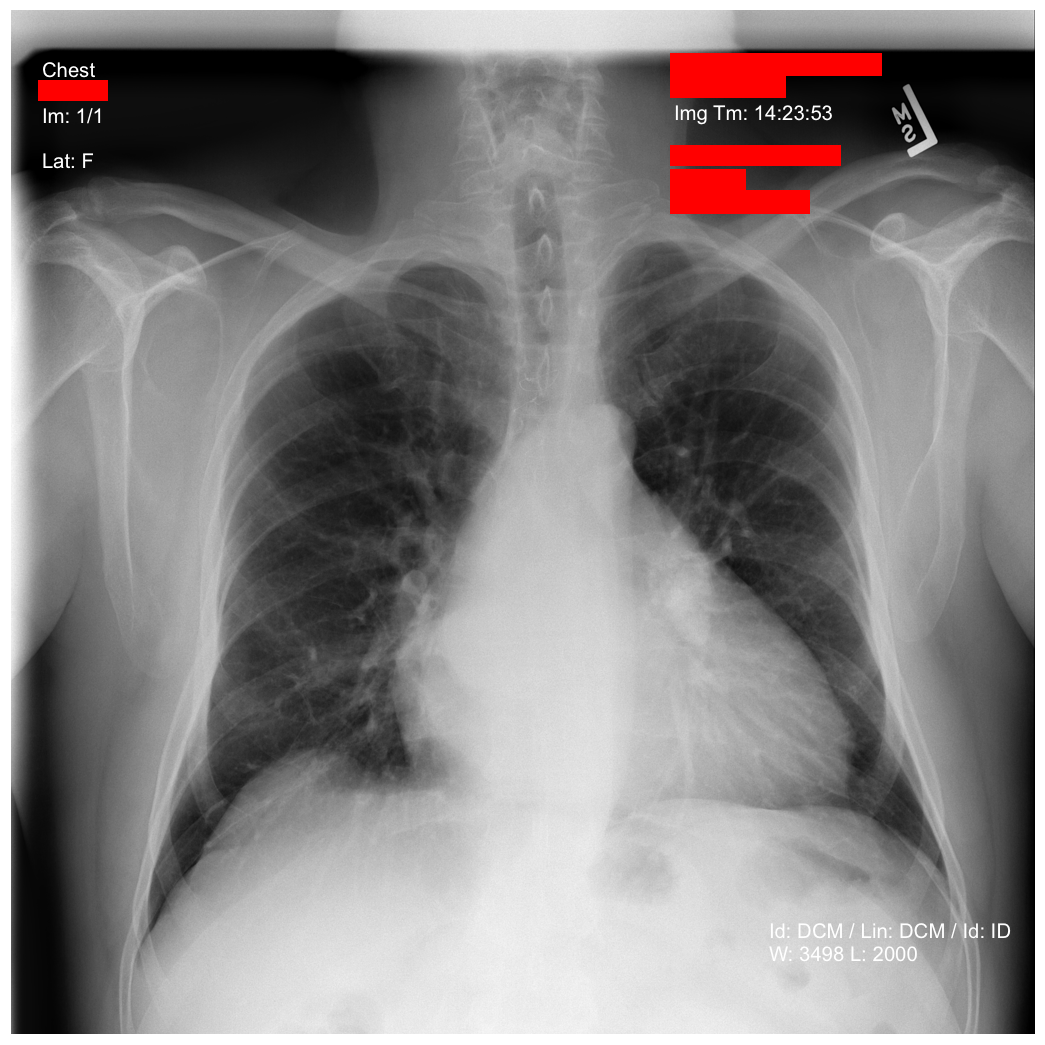

In [4]:
#Now this list of bounding boxes will be used to draw red boxes over the PHI text.
height, width = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img)
plt.imshow(img, cmap='gray')
for box in phi_boxes_list:
    #The bounding boxes are described as a ratio of the overall image dimensions, so we must multiply them
    #by the total image dimensions to get the exact pixel values for each dimension.
    x = img.shape[0] * box['Left']
    y = img.shape[1] * box['Top']
    width = img.shape[0] * box['Width']
    height = img.shape[1] * box['Height']
    rect = patches.Rectangle((x,y),width,height,linewidth=0,edgecolor=redacted_box_color,facecolor=redacted_box_color)
    ax.add_patch(rect)
#Ensure that no axis or whitespaces is printed in the image file we want to save.
plt.axis('off')    
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#Save redacted medical image to the same Amazon S3 bucket, in PNG format, with 'de-id-' in front of the original
#filename.
img_data = io.BytesIO()
plt.savefig(img_data, bbox_inches='tight', pad_inches=0, format='png')
img_data.seek(0)
#Uncomment the line below to write the redacted image to S3
#img_bucket.put_object(Body=img_data, ContentType='image/png', Key='de-id-'+object)